**Previsione dell'affidabilità creditizia per il rilascio della carta di credito**

Il progetto consiste nel creare un modello di Machine Learning capace di classificare "buoni" e "cattivi" clienti di una banca, per il rilascio della carta di credito.

# Import delle librerie

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.stats import chi2_contingency
import scipy.stats as stats
from math import floor

# Import del dataset

In [3]:
df =pd.read_csv('credit_scoring.csv', index_col=0)
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
ID,,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


# Exploratory Data Analysis

Ho distinto le variabili numeriche da quelle categoriali

In [4]:
X_num = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']
X_cat = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']
ins_var = []

Ho imputato i dati mancanti con la media per le variabili numeriche e la moda per quelle categoriali

In [5]:
# Imputazione della media per le colonne numeriche
mean_imputer = SimpleImputer(strategy='mean')
df[X_num] = mean_imputer.fit_transform(df[X_num])

# Imputazione della moda per le colonne categoriali
mode_imputer = SimpleImputer(strategy='most_frequent')
df[X_cat] = mode_imputer.fit_transform(df[X_cat])

t-test al fine di verificare l'esistenza di relazioni tra le suddette variabili e la variabile TARGET

In [6]:
for i in X_num:
  print(f't test between {i} and TARGET')
  group1 = df[df['TARGET'] == 1][i]  # Campioni con TARGET = 1
  group2 = df[df['TARGET'] == 0][i]  # Campioni con TARGET = 0

  # Calcola il test t per campioni indipendenti
  t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False)

  # Stampa i risultati
  print(f"T Statistic: {t_statistic}")
  print(f"P Value: {p_value}")

  # Interpretazione dei risultati
  if p_value < 0.05:
      print("Reject null hypothesis: there is a difference in mean between the groups.")
  else:
      print("Fail to reject null hypothesis: there isn't a difference in mean between the groups.")
      ins_var.append(i)
  print("-----")


t test between CNT_CHILDREN and TARGET
T Statistic: -69.40786787727484
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
t test between AMT_INCOME_TOTAL and TARGET
T Statistic: 114.50262398816734
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
t test between DAYS_BIRTH and TARGET
T Statistic: -197.3612927347842
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
t test between DAYS_EMPLOYED and TARGET
T Statistic: -274.90359730621867
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----
t test between CNT_FAM_MEMBERS and TARGET
T Statistic: -55.39238556022882
P Value: 0.0
Reject null hypothesis: there is a difference in mean between the groups.
-----


Test del chi-quadro per verificare l'esistenza di relazioni tra le suddette variabili e la variabile TARGET

In [7]:
for i in X_cat:
    print(f'Chi-squared test between {i} and TARGET')

    # Creare la tabella di contingenza tra TARGET e la variabile categorica
    contingency_table = pd.crosstab(df['TARGET'],df[i])

    # Calcolare il test chi-quadro
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

    # Visualizzare il p-value
    print(f'p-value: {p_val}')

    # Interpretazione del risultato
    if p_val < 0.05:
        print('There is a dependency between the variables.')
    else:
        print('There is no dependency between the variables.')
        ins_var.append(i)
    print('----------')

Chi-squared test between CODE_GENDER and TARGET
p-value: 5.107121242902283e-18
There is a dependency between the variables.
----------
Chi-squared test between FLAG_OWN_CAR and TARGET
p-value: 3.1228006804811466e-89
There is a dependency between the variables.
----------
Chi-squared test between FLAG_OWN_REALTY and TARGET
p-value: 1.1476101948675578e-68
There is a dependency between the variables.
----------
Chi-squared test between NAME_INCOME_TYPE and TARGET
p-value: 0.0
There is a dependency between the variables.
----------
Chi-squared test between NAME_EDUCATION_TYPE and TARGET
p-value: 2.540086168079669e-120
There is a dependency between the variables.
----------
Chi-squared test between NAME_FAMILY_STATUS and TARGET
p-value: 3.848824632596702e-98
There is a dependency between the variables.
----------
Chi-squared test between NAME_HOUSING_TYPE and TARGET
p-value: 1.265633051272072e-212
There is a dependency between the variables.
----------
Chi-squared test between FLAG_MOBIL an

# Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338427 entries, 5008804 to 6392180
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          338427 non-null  object 
 1   FLAG_OWN_CAR         338427 non-null  object 
 2   FLAG_OWN_REALTY      338427 non-null  object 
 3   CNT_CHILDREN         338427 non-null  float64
 4   AMT_INCOME_TOTAL     338427 non-null  float64
 5   NAME_INCOME_TYPE     338427 non-null  object 
 6   NAME_EDUCATION_TYPE  338427 non-null  object 
 7   NAME_FAMILY_STATUS   338427 non-null  object 
 8   NAME_HOUSING_TYPE    338427 non-null  object 
 9   DAYS_BIRTH           338427 non-null  float64
 10  DAYS_EMPLOYED        338427 non-null  float64
 11  FLAG_MOBIL           338427 non-null  object 
 12  FLAG_WORK_PHONE      338427 non-null  object 
 13  FLAG_PHONE           338427 non-null  object 
 14  FLAG_EMAIL           338427 non-null  object 
 15  OCCUPATION_TYPE

Encoding delle variabili categoriali

In [9]:
print(df['CODE_GENDER'].value_counts())
map_gen = {'M':1, 'F':0}
df['CODE_GENDER'] = df['CODE_GENDER'].map(map_gen)

CODE_GENDER
F    227916
M    110511
Name: count, dtype: int64


In [10]:
print(df['FLAG_OWN_CAR'].value_counts())
map_gen = {'Y':1, 'N':0}
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map(map_gen)

FLAG_OWN_CAR
N    213196
Y    125231
Name: count, dtype: int64


In [11]:
print(df['FLAG_OWN_REALTY'].value_counts())
map_gen = {'Y':1, 'N':0}
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map(map_gen)

FLAG_OWN_REALTY
Y    231307
N    107120
Name: count, dtype: int64


In [12]:
df = pd.get_dummies(df, columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,1,0.0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,...,True,False,False,False,False,False,False,False,False,False
5008805,1,1,1,0.0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,...,True,False,False,False,False,False,False,False,False,False
5008806,1,1,1,0.0,112500.0,-21474.0,-1134.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
5008808,0,0,1,0.0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,...,False,False,False,False,False,False,True,False,False,False
5008809,0,0,1,0.0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,...,False,False,False,False,False,False,True,False,False,False


Ho trasformato la variabile DAYS_BIRTH in modo tale da avere una nuova variabile AGE. Inoltre ho cambiato il segno della variabile DAYS_EMPLOYED per averne una migliore interpretabilità

In [13]:
df['DAYS_BIRTH']=df['DAYS_BIRTH'].abs()
df['AGE'] = df['DAYS_BIRTH'] / 365
df['AGE'] = df['AGE'].apply(floor)

In [14]:
#inverto il sergno della variabile DAYS_EMPLOYED
df["DAYS_EMPLOYED"] = -df["DAYS_EMPLOYED"]

  # Modello

Scelgo le variabili da inserire nel modello e divido il dataset in train e test

In [15]:
print(ins_var)

['FLAG_MOBIL']


ho deciso di escludere la variabile FLAG_MOBIL e sostituire DAYS_BIRTH con AGE

In [16]:
X = df.drop(['TARGET', 'FLAG_MOBIL', 'DAYS_BIRTH'], axis = 1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)

Ho controllato se la variabile TARGET presentasse uno sbilanciamento delle classi

In [17]:
df['TARGET'].value_counts()

,count
TARGET,
0,308705
1,29722


Avendo constatato che la variabile TARGET è composta da classi sbilanciate, ho confrontato diverse alternative:

1) parametro class_weight = "balanced"

2) SMOTE

3) Undersampling casuale

In [18]:
#oversampling
smote = SMOTE(random_state=42)
X_train_ov, y_train_ov = smote.fit_resample(X_train, y_train)
#undersampling
rnd = RandomUnderSampler(random_state=42)
X_train_un, y_train_un = rnd.fit_resample(X_train, y_train)

ss = StandardScaler()

X_train[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']]  = ss.fit_transform(X_train[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']])
X_train = X_train.values

X_train_ov[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']]  = ss.fit_transform(X_train_ov[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']])
X_train_ov = X_train_ov.values

X_train_un[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']]  = ss.fit_transform(X_train_un[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']])
X_train_un = X_train_un.values

X_test[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']] = ss.transform(X_test[['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AGE']])
X_test = X_test.values

y_train = y_train.values
y_train_ov = y_train_ov.values
y_train_un = y_train_un.values

y_test = y_test.values




Ho utilizzato come modello l'algoritmo delle Random Forests

In [19]:
forest = RandomForestClassifier(100,class_weight='balanced',random_state=42)

Ho definito una funzione che mostra le principali misure di valutazione di un modello di machine learning con task di classificazione

In [23]:
def classifier_report(model, X_train, X_test, y_train, y_test):
  print(model)
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print('Train set')
  precision_class_0 = round(precision_score(y_train, y_train_pred, pos_label=0),2)
  precision_class_1 = round(precision_score(y_train, y_train_pred, pos_label=1),2)
  train_accuracy = round(accuracy_score(y_train, y_train_pred),2)
  print(f'Train accuracy: {train_accuracy}')
  print('Test set')
  precision_class_0 = round(precision_score(y_test, y_test_pred, pos_label=0),2)
  precision_class_1 = round(precision_score(y_test, y_test_pred, pos_label=1),2)
  recall_class_0 = round(recall_score(y_test, y_test_pred, pos_label=0),2)
  recall_class_1 = round(recall_score(y_test, y_test_pred, pos_label=1),2)
  test_accuracy = round(accuracy_score(y_test, y_test_pred),2)
  print(f'Precision class 0: {precision_class_0}')
  print(f'Precision class 1: {precision_class_1}')
  print(f'Recall class 0: {recall_class_0}')
  print(f'Recall class 1: {recall_class_1}')
  print(f'Accuracy: {test_accuracy}')


RISULTATI



In [24]:
print('ORIGINAL DATA')
classifier_report(model=forest,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)

print('-----')

print('OVERSAMPLING')
classifier_report(model=forest,X_train=X_train_ov,X_test=X_test,y_train=y_train_ov,y_test=y_test)

print('-----')

print('UNDERSAMPLING')
classifier_report(model=forest,X_train=X_train_un,X_test=X_test,y_train=y_train_un,y_test=y_test)


ORIGINAL DATA
RandomForestClassifier(class_weight='balanced', random_state=42)
Train set
Train accuracy: 0.97
Test set


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision class 0: 0.91
Precision class 1: 0.0
Recall class 0: 1.0
Recall class 1: 0.0
Accuracy: 0.91
-----
OVERSAMPLING
RandomForestClassifier(class_weight='balanced', random_state=42)
Train set
Train accuracy: 0.98
Test set
Precision class 0: 0.99
Precision class 1: 0.7
Recall class 0: 0.96
Recall class 1: 0.89
Accuracy: 0.96
-----
UNDERSAMPLING
RandomForestClassifier(class_weight='balanced', random_state=42)
Train set
Train accuracy: 0.98
Test set
Precision class 0: 1.0
Precision class 1: 0.7
Recall class 0: 0.96
Recall class 1: 0.99
Accuracy: 0.96


Dalle misure di valuazione dei modelli si evince che si ottengono migliori performance ricorrendo all'undersampling casuale

In [25]:
forest.fit(X_train_un, y_train_un)

RandomForestClassifier(class_weight='balanced', random_state=42)

#Interpretazione

Feature Importance

In [26]:
# Ottieni l'importanza delle feature
feature_importances = forest.feature_importances_

# Creare un DataFrame per una visualizzazione più leggibile
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizzare il DataFrame
print(feature_importance_df)


                                              Feature    Importance
50                                                AGE  3.257486e-01
5                                       DAYS_EMPLOYED  2.724487e-01
4                                    AMT_INCOME_TOTAL  2.716891e-01
11                         NAME_INCOME_TYPE_Pensioner  3.325748e-02
3                                        CNT_CHILDREN  1.141497e-02
9                                     CNT_FAM_MEMBERS  1.100693e-02
40                           OCCUPATION_TYPE_Laborers  8.083716e-03
14                           NAME_INCOME_TYPE_Working  6.269040e-03
10              NAME_INCOME_TYPE_Commercial associate  4.622507e-03
0                                         CODE_GENDER  3.706516e-03
1                                        FLAG_OWN_CAR  3.697872e-03
42                           OCCUPATION_TYPE_Managers  3.630827e-03
6                                     FLAG_WORK_PHONE  3.525026e-03
7                                          FLAG_

Algoritmo Shap per ottenere anche un verso della relazione tra la variabile TARGET e le variabili indipendenti

In [27]:
import shap

shap_ = shap.TreeExplainer(forest)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
print(X_test_df.shape)

(101529, 51)


A causa dell'elevato costo computazionale dell'algoritmo ho deciso di estrarre casualmenete 5.000 osservazioni dal test set

In [28]:
X_test_df_sample = X_test_df.sample(n=5000, replace = False)
print(X_test_df_sample.shape)

(5000, 51)


In [29]:
shap_val = shap_(X_test_df_sample)

Si conclude che l'affidabilità creditizia è legata ad una maggiore esperienza lavorativa, la quale è indice di redditi più elevati

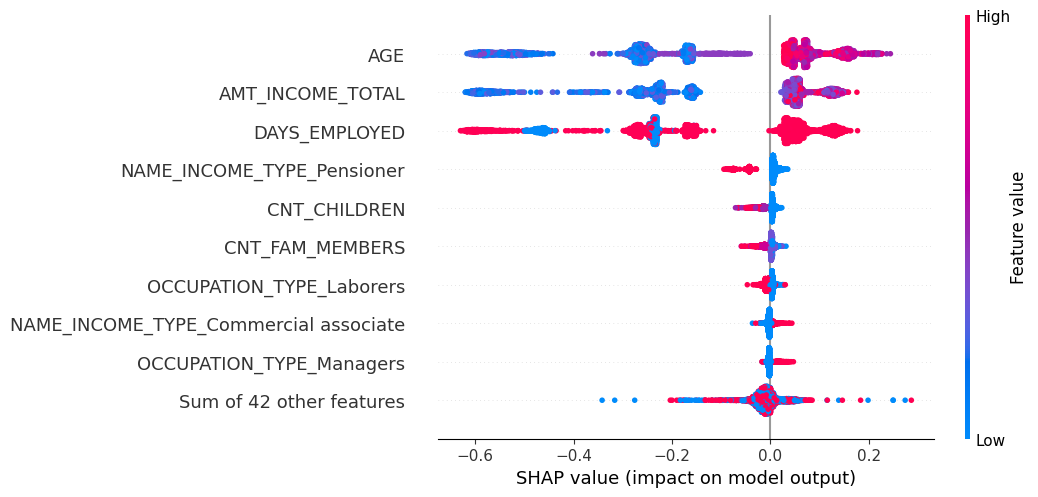

In [30]:
shap.plots.beeswarm(shap_val[:,:,1])